In [1]:
from pyspark.sql import SparkSession, functions as F
from pyspark.sql.functions import *
from pyspark.ml.regression import GBTRegressor
import numpy as np

spark = (
    SparkSession.builder.appName("ADS project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/07 23:05:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/07 23:06:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/10/07 23:06:01 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
df = spark.read.parquet('../data/curated/merchant_consumer_abs')

In [3]:
df

22/10/07 23:06:13 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


postcode,total_earners,median_age,income_sum,2021_population,km2,income_mean,persons/km2,merchant_name,revenue_level,user_id,order_datetime,products,take_rate,category,dollar_value,order_year,order_month,order_day,consumer,consumer_address,consumer_state,consumer_postcode,consumer_gender,fraud_group,__index_level_0__
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,10413,2022-04-27,artist supply and...,5.89,art and gifts,375.16773164703153,2022,4,27,Kelly Clayton,4211 Rodney Tunne...,NT,0800,Female,0,0
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,22246,2022-10-07,artist supply and...,5.89,art and gifts,617.8791313462011,2022,10,7,Corey Estrada,1703 Boyd Shore,NT,0800,Male,0,1
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,2681,2022-02-28,artist supply and...,5.89,art and gifts,766.5077067424303,2022,2,28,Nicole Bishop,467 Robert Island...,NT,0800,Female,0,2
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Malesuada Vel Ltd,b,13454,2021-07-24,books periodicals...,3.56,books and music,258.86595899218753,2021,7,24,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,3
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Varius Orci Insti...,a,10146,2021-08-08,tent and awning s...,6.3,outdoors,4.159037931172075,2021,8,8,Shannon Mann,00817 Owens Circle,NT,0800,Female,0,4
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Volutpat Nulla In...,a,23093,2022-10-11,furniture home fu...,6.59,home and technology,8.26105405068297,2022,10,11,Robert Walker,646 Allison Ranch...,NT,0800,Male,0,5
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Mollis Integer Co...,b,13454,2022-05-02,digital goods boo...,3.96,books and music,83.63154755239155,2022,5,2,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,6
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Elit Sed Consequa...,a,13454,2021-04-08,artist supply and...,5.89,art and gifts,87.00495112586256,2021,4,8,Natalie Herrera,88798 Saunders Hi...,NT,0800,Female,0,7
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Eros Limited,c,8092,2021-12-18,digital goods boo...,2.52,books and music,8.26187754879106,2021,12,18,Rebecca Owens,92579 Keith Neck ...,NT,0800,Female,0,8
0800,5631.999973601934,36.75,4.20609029345557E8,7678.999968193022,3.199999994700948,74682.00129918633,2399.687494034091,Hendrerit A Corpo...,a,11203,2022-07-14,watch clock and j...,6.64,fashion and acces...,100.80643267043831,2022,7,14,John Rodriguez,563 Wallace Rue,NT,0800,Male,0,9


<h2>1. Split dataset</h2>

In [4]:
import time
import datetime
date = "2022-08-28" # 2022 week34
date_time = datetime.datetime.strptime(date, '%Y-%m-%d')

In [5]:
df_train = df.where((col("order_datetime") <= date_time.date()))
df_train.count()

10547891

In [6]:
df_test = df.where((col("order_datetime") > date_time.date()))
df_test.count()

1372562

<h2>2. Aggregate dataset</h2>

In [7]:
df_train_agg = df_train.groupBy(["merchant_name", "order_year", "order_month"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable
    
    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_mean").alias("income_mean"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

df_test_agg = df_test.groupBy(["merchant_name", "order_year", "order_month"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable

    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_mean").alias("income_mean"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

In [8]:
df_all = df.groupBy(["merchant_name", "order_year", "order_month"]).agg(
    sum("dollar_value").alias("total_revenue"), # response variable

    max("take_rate").alias("take_rate"),
    avg("total_earners").alias("total_earners"),
    avg("median_age").alias("median_age"),
    avg("income_mean").alias("income_mean"),
    avg("persons/km2").alias("population_density"),
    max("category").alias("category"),
    max("revenue_level").alias("revenue_level")
    )

In [9]:
df_train_agg = df_train_agg.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))
df_test_agg = df_test_agg.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))
df_all = df_all.withColumn("revenue_taken", F.col("total_revenue") * (F.col("take_rate") / 100))

In [10]:
df_train_agg = df_train_agg.drop("total_revenue", "take_rate")
df_test_agg = df_test_agg.drop("total_revenue", "take_rate")
df_all = df_all.drop("total_revenue", "take_rate")

In [11]:
df_train_agg

merchant_name,order_year,order_month,total_earners,median_age,income_mean,population_density,category,revenue_level,revenue_taken
A Aliquet Ltd,2021,3,4963.535710919874,46.28955171812314,57913.51803834353,862.8285103360431,home and technology,b,373.77697013949444
A Aliquet Ltd,2021,4,5378.752132336274,45.423016497391494,62253.6709383582,864.9509643464004,home and technology,b,372.1116611140632
A Aliquet Ltd,2021,7,4455.927321143453,46.131816028136775,59517.415987420754,724.9177384229837,home and technology,b,496.0554179068632
A Aliquet Ltd,2021,8,5357.976855749735,45.23299791225323,60204.26622857647,816.452153604271,home and technology,b,390.589791792713
A Aliquet Ltd,2021,12,4393.274654220205,45.51620695777413,67688.91633932825,837.3796476776628,home and technology,b,575.4017982179806
A Aliquet Ltd,2022,6,4985.763543623209,45.277045531300836,64525.12409994341,544.2014361286423,home and technology,b,422.6733449554339
A Aliquet Ltd,2022,8,4270.419475515142,45.937046939988115,61522.15947903654,601.7347438561001,home and technology,b,479.1037508352853
A Arcu Industries,2021,2,3464.1233178609377,46.65873015873016,61669.384381820455,5.0625991530171195,outdoors,c,21.744568393051882
A Arcu Industries,2021,12,4637.594326362481,45.62602565787575,67956.54853821809,719.6061210540767,outdoors,c,1662.3730804995278
A Arcu Industries,2022,5,5092.47781939494,44.44866689337308,63950.030918709184,1095.7006288729813,outdoors,c,1314.1422199135288


In [12]:
df_train_agg.printSchema()

root
 |-- merchant_name: string (nullable = true)
 |-- order_year: integer (nullable = true)
 |-- order_month: integer (nullable = true)
 |-- total_earners: double (nullable = true)
 |-- median_age: double (nullable = true)
 |-- income_mean: double (nullable = true)
 |-- population_density: double (nullable = true)
 |-- category: string (nullable = true)
 |-- revenue_level: string (nullable = true)
 |-- revenue_taken: double (nullable = true)



In [13]:
from xxlimited import Str
from pyspark.ml.feature import OneHotEncoder, StringIndexer

stringIndexer = StringIndexer(inputCols=["category", "revenue_level"], outputCols=["category_num", "revenue_num"])
model = stringIndexer.fit(df_train_agg)
train1 = model.transform(df_train_agg)

model = stringIndexer.fit(df_test_agg)
test1 = model.transform(df_test_agg)


In [14]:

encoder = OneHotEncoder(inputCols=["category_num", "revenue_num"], outputCols=["category_vec", "revenue_vec"])
train = encoder.fit(train1).transform(train1).drop("category_num", "revenue_num")
test = encoder.fit(test1).transform(test1).drop("category_num", "revenue_num")


In [15]:
train

merchant_name,order_year,order_month,total_earners,median_age,income_mean,population_density,category,revenue_level,revenue_taken,category_vec,revenue_vec
A Aliquet Ltd,2021,3,4963.535710919874,46.28955171812314,57913.51803834353,862.8285103360431,home and technology,b,373.77697013949444,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,4,5378.752132336274,45.423016497391494,62253.6709383582,864.9509643464004,home and technology,b,372.1116611140632,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,7,4455.927321143453,46.131816028136775,59517.415987420754,724.9177384229837,home and technology,b,496.0554179068632,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,8,5357.976855749735,45.23299791225323,60204.26622857647,816.452153604271,home and technology,b,390.589791792713,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2021,12,4393.274654220205,45.51620695777413,67688.91633932825,837.3796476776628,home and technology,b,575.4017982179806,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2022,6,4985.763543623209,45.277045531300836,64525.12409994341,544.2014361286423,home and technology,b,422.6733449554339,"(4,[0],[1.0])","(4,[1],[1.0])"
A Aliquet Ltd,2022,8,4270.419475515142,45.937046939988115,61522.15947903654,601.7347438561001,home and technology,b,479.1037508352853,"(4,[0],[1.0])","(4,[1],[1.0])"
A Arcu Industries,2021,2,3464.1233178609377,46.65873015873016,61669.384381820455,5.0625991530171195,outdoors,c,21.744568393051882,"(4,[2],[1.0])","(4,[2],[1.0])"
A Arcu Industries,2021,12,4637.594326362481,45.62602565787575,67956.54853821809,719.6061210540767,outdoors,c,1662.3730804995278,"(4,[2],[1.0])","(4,[2],[1.0])"
A Arcu Industries,2022,5,5092.47781939494,44.44866689337308,63950.030918709184,1095.7006288729813,outdoors,c,1314.1422199135288,"(4,[2],[1.0])","(4,[2],[1.0])"


In [16]:
# vectorized the features for model training
from pyspark.ml.feature import VectorAssembler

features = 'features'
internal_cols = ["order_year", "order_month", "category_vec", "revenue_vec"]
external_cols = ["total_earners", "median_age", "income_mean", "population_density"]

assembler = VectorAssembler(
    # which column to combine
    inputCols=internal_cols, 
    # How should the combined columns be named
    outputCol="internal"
)
train = assembler.transform(train.dropna('any'))
test = assembler.transform(test.dropna('any'))

assembler = VectorAssembler(
    # which column to combine
    inputCols=external_cols, 
    # How should the combined columns be named
    outputCol="external"
)
train = assembler.transform(train.dropna('any'))
test = assembler.transform(test.dropna('any'))

In [17]:
from pyspark.ml.feature import Interaction

interaction1 = Interaction(inputCols=internal_cols, outputCol="internal_interact")
train = interaction1.transform(train)
test = interaction1.transform(test)

In [18]:
train.select("internal_interact", "internal").show(truncate=False)

+-------------------+------------------------------------+
|internal_interact  |internal                            |
+-------------------+------------------------------------+
|(16,[1],[6063.0])  |(10,[0,1,2,7],[2021.0,3.0,1.0,1.0]) |
|(16,[1],[8084.0])  |(10,[0,1,2,7],[2021.0,4.0,1.0,1.0]) |
|(16,[1],[14147.0]) |(10,[0,1,2,7],[2021.0,7.0,1.0,1.0]) |
|(16,[1],[16168.0]) |(10,[0,1,2,7],[2021.0,8.0,1.0,1.0]) |
|(16,[1],[24252.0]) |(10,[0,1,2,7],[2021.0,12.0,1.0,1.0])|
|(16,[1],[12132.0]) |(10,[0,1,2,7],[2022.0,6.0,1.0,1.0]) |
|(16,[1],[16176.0]) |(10,[0,1,2,7],[2022.0,8.0,1.0,1.0]) |
|(16,[10],[4042.0]) |(10,[0,1,4,8],[2021.0,2.0,1.0,1.0]) |
|(16,[10],[24252.0])|(10,[0,1,4,8],[2021.0,12.0,1.0,1.0])|
|(16,[10],[10110.0])|(10,[0,1,4,8],[2022.0,5.0,1.0,1.0]) |
|(16,[10],[12132.0])|(10,[0,1,4,8],[2022.0,6.0,1.0,1.0]) |
|(16,[14],[16176.0])|(10,[0,1,5,8],[2022.0,8.0,1.0,1.0]) |
|(16,[6],[14147.0]) |(10,[0,1,3,8],[2021.0,7.0,1.0,1.0]) |
|(16,[6],[20210.0]) |(10,[0,1,3,8],[2021.0,10.0,1.0,1.0]

In [19]:
from pyspark.ml.feature import Interaction

interaction2 = Interaction(inputCols=["internal", "external"], outputCol="external_interact")
train = interaction2.transform(train)
test = interaction2.transform(test)

In [20]:
assembler1 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols, 
    # How should the combined columns be named
    outputCol="feature_additive"
)

train = assembler1.transform(train)
test = assembler1.transform(test)

In [21]:

assembler2 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols + ["internal_interact"], 
    # How should the combined columns be named
    outputCol="feature_internal"
)

train = assembler2.transform(train)
test = assembler2.transform(test)

In [22]:
assembler3 = VectorAssembler(
    # which column to combine
    inputCols=external_cols + internal_cols + ["internal_interact"] + ["external_interact"], 
    # How should the combined columns be named
    outputCol="feature_all"
)

train = assembler3.transform(train)
test = assembler3.transform(test)

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_real_vs_pred(model_name, y_real, y_pred):
    plt.style.use('ggplot')
    reg_real_vs_pred = pd.concat([y_real, y_pred], axis = 1)
    reg_real_vs_pred = reg_real_vs_pred.head(60)
    reg_real_vs_pred.plot(kind='bar', title='MODEL: '+model_name, figsize=(16,5))
    plt.show()

## 3. Gradient Boost Tree

In [24]:
from pyspark.ml.regression import GBTRegressor

# Define Gradient boosted tree regression algorithm
rf_additive = GBTRegressor(maxDepth=6, 
                            featuresCol='feature_additive', 
                            labelCol='revenue_taken',
                            ).fit(train)

rf_internal = GBTRegressor(maxDepth=6, 
                  featuresCol='feature_internal', 
                  labelCol='revenue_taken',
                  ).fit(train)

rf_all = GBTRegressor(maxDepth=7, 
                  featuresCol='feature_all', 
                  labelCol='revenue_taken',
                  ).fit(train)

In [25]:
predictions_additive = rf_additive.transform(test)
predictions_internal = rf_internal.transform(test)
predictions_all = rf_all.transform(test)

In [26]:
from pyspark.ml.evaluation import RegressionEvaluator
# Select (prediction, true label) and compute test error
evaluator = RegressionEvaluator(labelCol="revenue_taken",
                                predictionCol="prediction",
                                metricName="rmse")


rmse_addtive = evaluator.evaluate(predictions_additive)
rmse_internal = evaluator.evaluate(predictions_internal)
rmse_all = evaluator.evaluate(predictions_all)
print("Root Mean Squared Error (RMSE) for additive model = %g" % rmse_addtive)
print("Root Mean Squared Error (RMSE) for internal interaction model = %g" % rmse_internal)
print("Root Mean Squared Error (RMSE) for full model = %g" % rmse_all)

22/10/07 23:15:28 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/10/07 23:15:28 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


Root Mean Squared Error (RMSE) for additive model = 1772.07
Root Mean Squared Error (RMSE) for internal interaction model = 1774.32
Root Mean Squared Error (RMSE) for full model = 1785.35


In [27]:
y_true_additive = predictions_additive.select("revenue_taken").toPandas()
y_pred_additive = predictions_additive.select("prediction").toPandas()

y_true_internal = predictions_internal.select("revenue_taken").toPandas()
y_pred_internal = predictions_internal.select("prediction").toPandas()

y_true_all = predictions_all.select("revenue_taken").toPandas()
y_pred_all = predictions_all.select("prediction").toPandas()

import sklearn.metrics
r2_score_additive = sklearn.metrics.r2_score(y_true_additive, y_pred_additive)
r2_score_internal = sklearn.metrics.r2_score(y_true_internal, y_pred_internal)
r2_score_all = sklearn.metrics.r2_score(y_true_all, y_pred_all)
print('r2_score_additive: {:4.3f}'.format(r2_score_additive))
print('r2_score_internal: {:4.3f}'.format(r2_score_internal))
print('r2_score_all: {:4.3f}'.format(r2_score_all))

r2_score_additive: 0.365
r2_score_internal: 0.363
r2_score_all: 0.355


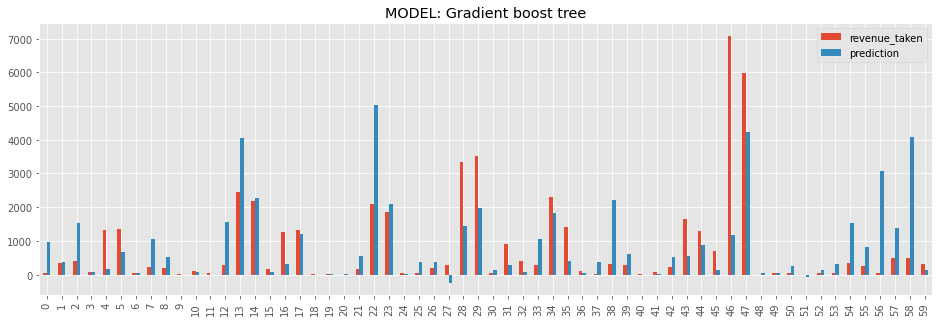

In [28]:
plot_real_vs_pred("Gradient boost tree", y_true_all, y_pred_all)

## 4. Random Forest Regressor

In [29]:
# Import Random Forest Regressor
from pyspark.ml.regression import RandomForestRegressor


rfR_additive = RandomForestRegressor(maxDepth=6, 
                  featuresCol='feature_additive', 
                  labelCol='revenue_taken',
                  ).fit(train)

rfR_internal = RandomForestRegressor(maxDepth=6, 
                  featuresCol='feature_internal', 
                  labelCol='revenue_taken',
                  ).fit(train)

rfR_all = RandomForestRegressor(maxDepth=7, 
                  featuresCol='feature_all', 
                  labelCol='revenue_taken',
                  ).fit(train)

In [30]:
predictions_additive_R = rfR_additive.transform(test)
predictions_internal_R = rfR_internal.transform(test)
predictions_all_R = rfR_all.transform(test)

In [31]:
rmse_addtive_R = evaluator.evaluate(predictions_additive_R)
rmse_internal_R = evaluator.evaluate(predictions_internal_R)
rmse_all_R = evaluator.evaluate(predictions_all_R)
print("Root Mean Squared Error (RMSE) for additive model = %g" % rmse_addtive_R)
print("Root Mean Squared Error (RMSE) for internal interaction model = %g" % rmse_internal_R)
print("Root Mean Squared Error (RMSE) for full model = %g" % rmse_all_R)

Root Mean Squared Error (RMSE) for additive model = 1906.1
Root Mean Squared Error (RMSE) for internal interaction model = 1917.54
Root Mean Squared Error (RMSE) for full model = 1827.76


In [32]:
y_true_additive_R = predictions_additive_R.select("revenue_taken").toPandas()
y_pred_additive_R = predictions_additive_R.select("prediction").toPandas()

y_true_internal_R = predictions_internal_R.select("revenue_taken").toPandas()
y_pred_internal_R = predictions_internal_R.select("prediction").toPandas()

y_true_all_R = predictions_all_R.select("revenue_taken").toPandas()
y_pred_all_R = predictions_all_R.select("prediction").toPandas()


r2_score_additive_R = sklearn.metrics.r2_score(y_true_additive_R, y_pred_additive_R)
r2_score_internal_R = sklearn.metrics.r2_score(y_true_internal_R, y_pred_internal_R)
r2_score_all_R = sklearn.metrics.r2_score(y_true_all_R, y_pred_all_R)
print('r2_score_additive: {:4.3f}'.format(r2_score_additive_R))
print('r2_score_internal: {:4.3f}'.format(r2_score_internal_R))
print('r2_score_all: {:4.3f}'.format(r2_score_all_R))

r2_score_additive: 0.265
r2_score_internal: 0.256
r2_score_all: 0.324


## 5. Transform the total revenue to score

In [33]:
df_all

merchant_name,order_year,order_month,total_earners,median_age,income_mean,population_density,category,revenue_level,revenue_taken
A Aliquet Ltd,2021,3,4963.535710919874,46.28955171812316,57913.51803834353,862.8285103360431,home and technology,b,373.7769701394945
A Aliquet Ltd,2021,4,5378.7521323362735,45.4230164973915,62253.6709383582,864.9509643464004,home and technology,b,372.1116611140632
A Aliquet Ltd,2021,7,4455.927321143454,46.131816028136775,59517.41598742075,724.9177384229837,home and technology,b,496.0554179068631
A Aliquet Ltd,2021,8,5357.976855749735,45.23299791225323,60204.266228576475,816.4521536042711,home and technology,b,390.5897917927129
A Aliquet Ltd,2021,12,4393.274654220204,45.51620695777413,67688.91633932824,837.3796476776628,home and technology,b,575.4017982179806
A Aliquet Ltd,2022,6,4985.7635436232085,45.27704553130086,64525.12409994342,544.2014361286423,home and technology,b,422.67334495543383
A Aliquet Ltd,2022,8,4450.017605152951,45.85536948431685,63998.28124203042,646.7015709015924,home and technology,b,543.1068713493326
A Arcu Industries,2021,2,3464.1233178609377,46.65873015873016,61669.384381820455,5.0625991530171195,outdoors,c,21.744568393051882
A Arcu Industries,2021,12,4637.594326362481,45.62602565787575,67956.54853821806,719.6061210540763,outdoors,c,1662.373080499528
A Arcu Industries,2022,5,5092.47781939494,44.44866689337308,63950.03091870917,1095.7006288729817,outdoors,c,1314.142219913529


In [34]:
revenue_score = df_all.groupBy(["merchant_name"]).agg(
    sum("revenue_taken").alias("total_revenue")
    )

In [35]:
revenue_score.orderBy("total_revenue")

merchant_name,total_revenue
Consectetuer Ipsu...,3.250765585109828
Faucibus Ltd,3.5512344419012583
Ac Eleifend Vitae...,3.9167039023366743
Velit Inc.,5.111416773814975
Magna Sed Associates,6.039746046534802
Nulla Limited,6.881752409537095
Egestas A Dui Corp.,7.733799649708853
Enim Etiam Institute,7.9729906258318834
Lacus LLP,8.36329741086963
Hendrerit Id Ante...,10.781037338047874


In [36]:
revenue_score = revenue_score.withColumn("a", lit("a"))

In [37]:
from pyspark.sql.window import Window
from pyspark.sql.functions import percent_rank

In [38]:
# Use the rank as the score
Window_Spec  = Window.partitionBy("a").orderBy("total_revenue")
revenue_score = revenue_score.withColumn("percent_rank", percent_rank().over(Window_Spec)) 


In [39]:
revenue_score

merchant_name,total_revenue,a,percent_rank
Consectetuer Ipsu...,3.250765585109828,a,0.0
Faucibus Ltd,3.5512344419012583,a,2.568053415511042...
Ac Eleifend Vitae...,3.9167039023366743,a,5.136106831022085E-4
Velit Inc.,5.111416773814975,a,7.704160246533128E-4
Magna Sed Associates,6.039746046534802,a,0.001027221366204417
Nulla Limited,6.881752409537095,a,0.001284026707755...
Egestas A Dui Corp.,7.733799649708853,a,0.001540832049306...
Enim Etiam Institute,7.9729906258318834,a,0.001797637390857...
Lacus LLP,8.36329741086963,a,0.002054442732408834
Hendrerit Id Ante...,10.781037338047874,a,0.002311248073959...


In [40]:
revenue_score = revenue_score.withColumn("revenue_score", F.col("percent_rank")).drop("a","percent_rank", "total_revenue")

#### Add variance as one metrics

In [41]:
df_variance = df.groupBy(["merchant_name"]).agg(
    variance("dollar_value").alias("variance")
    )

In [42]:
df_variance = df_variance.fillna(value = 0)

In [43]:
from pyspark.ml.feature import StandardScaler


# VectorAssembler Transformation - Converting column to vector type
assembler_vec = VectorAssembler(inputCols=["variance"],outputCol="variance_Vect")
variance_score = assembler_vec.transform(df_variance)

scaler = StandardScaler(inputCol="variance_Vect", outputCol="variance_score",
                        withStd=True, withMean=False)


# Standardise the trend score (since it contain negative value) as score

from pyspark.ml.functions import vector_to_array
variance_score = scaler.fit(variance_score).transform(variance_score).drop("variance","variance_Vect").withColumn("variance_score", vector_to_array("variance_score")[0])


In [44]:
variance_score = variance_score.withColumnRenamed("merchant_name", "name")

revenue_score = revenue_score.join(variance_score, variance_score.name ==  revenue_score.merchant_name,"inner").drop("name")

In [45]:
revenue_score

merchant_name,revenue_score,variance_score
Consectetuer Ipsu...,0.0,0.0
Faucibus Ltd,2.568053415511042...,0.0
Ac Eleifend Vitae...,5.136106831022085E-4,0.0
Velit Inc.,7.704160246533128E-4,0.0
Magna Sed Associates,0.001027221366204417,0.0
Nulla Limited,0.001284026707755...,0.0
Egestas A Dui Corp.,0.001540832049306...,3.2898949522111685
Enim Etiam Institute,0.001797637390857...,1.958919765612116
Lacus LLP,0.002054442732408834,0.6446990488357244
Hendrerit Id Ante...,0.002311248073959...,0.0


#### Combined with train score

In [47]:
trend = spark.read.option("header", "true").csv("../data/curated/increasing.csv")

In [51]:
trend = trend.withColumn("monthly_increase_rate", F.col("monthly_increase_rate").cast("double"))

In [52]:
trend

merchant_name,monthly_increase_rate
Dis Parturient Mo...,-89.23230623260663
Posuere At Velit ...,-2188.963037874791
Sed Pharetra Ltd,-126.06630122868519
A Magna Lorem Ltd,2517.521237796379
Accumsan Corporation,-22.824730059282366
Tellus Imperdiet LLP,-101.33981334742475
A Company,-208.22641438607835
Ut Nec Urna LLP,-304.73665282602667
Aliquam Ornare Inc.,165.02416637129028
Odio Etiam Corpor...,564.9147457557135


In [54]:
from pyspark.ml.feature import StandardScaler


# VectorAssembler Transformation - Converting column to vector type
assembler_vec = VectorAssembler(inputCols=["monthly_increase_rate"],outputCol="increasing_Vect")
trend_score = assembler_vec.transform(trend)

scaler = StandardScaler(inputCol="increasing_Vect", outputCol="trend_score",
                        withStd=True, withMean=False)


# Standardise the trend score (since it contain negative value) as score

from pyspark.ml.functions import vector_to_array
trend_score = scaler.fit(trend_score).transform(trend_score).drop("increasing","increasing_Vect").withColumn("trend_score", vector_to_array("trend_score")[0])



In [55]:
trend_score = trend_score.withColumnRenamed("merchant_name", "name")

In [56]:
trend_revenue_final = revenue_score.join(trend_score, trend_score.name ==  revenue_score.merchant_name,"inner").drop("name")

In [57]:
trend_revenue_final

merchant_name,revenue_score,variance_score,monthly_increase_rate,trend_score
Consectetuer Ipsu...,0.0,0.0,15.935125417205038,0.011874444528407297
Faucibus Ltd,2.568053415511042...,0.0,-15.241349536056902,-0.0113574606327584
Ac Eleifend Vitae...,5.136106831022085E-4,0.0,14.038365241350087,0.010461027758711603
Velit Inc.,7.704160246533128E-4,0.0,-10.141699948045586,-0.00755733326872...
Magna Sed Associates,0.001027221366204417,0.0,16.777072351485558,0.012501841671838765
Nulla Limited,0.001284026707755...,0.0,-39.32429948306911,-0.02930345388596...
Egestas A Dui Corp.,0.001540832049306...,3.2898949522111685,-72.76585369598567,-0.05422323769992234
Enim Etiam Institute,0.001797637390857...,1.958919765612116,-398.51005677187663,-0.2969594175920883
Lacus LLP,0.002054442732408834,0.6446990488357244,230.52474813545177,0.17178109757479443
Hendrerit Id Ante...,0.002311248073959...,0.0,-73.34039005474744,-0.05465136737841...


In [58]:
trend_revenue_final.count()

3895

In [59]:
trend_revenue_final.write.parquet("../data/curated/revenue_trend_score")